In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scripts.visualize import load_experiment, load_baseline
import pkufiber as pf
from pkufiber.dsp.nonlinear_compensation.loss import  avg_phase 
import torch

def rotation_qfactor(path):
    qfactor = []
    pch = range(-3, 5)

    if  os.path.exists(path+'/results/qfactor_rotation.npy'):
        return np.load(path+'/results/qfactor_rotation.npy'), pch
    
    for i in pch:
        x = np.load(path+f'/results/x_{i}dBm.npy')
        y = np.load(path+f'/results/y_{i}dBm.npy')
        theta = torch.mean(avg_phase(torch.tensor(x), torch.tensor(y)))
        if x.ndim == 3:
            qfactor.append(pf.qfactor_all(np.concatenate(y, axis=0)*np.exp(1j*theta.item()), np.concatenate(x, axis=0)))
        elif x.ndim == 2:
            qfactor.append(pf.qfactor_all(y*np.exp(1j*theta.item()), x))
        else:
            raise ValueError('Invalid dimension')
        
    np.save(path+'/results/qfactor_rotation.npy', qfactor)
    return qfactor, pch

def origin_qfactor(path):
    res = load_experiment(path)
    return res['qfactor_power'][0], res['qfactor_power'][1]

def rmps(path):
    res = load_experiment(path)
    return res['model'].rmps()



scatter_params = {
    '_stftpbc_': {'color': 'b', 'marker': '*', 'label': 'VSTF'},
    '_stftampbc_': {'color': 'brown', 'marker': 'h', 'label': 'AMVSTF'},
    '_ampbc_': {'color': 'c', 'marker': 's', 'label': 'AMPBC'},
    '_pbc_': {'color': 'r', 'marker': 'o', 'label': 'PBC'},
    '_eqfdbp_': {'color': 'c', 'marker': 'o', 'label': 'FDBP(sps=1)'},
    # '_fdbp_': {'color': 'r', 'marker': 'x', 'label': 'FDBP(sps=2)'},
    '_eqsnsedbp_': {'color': 'm', 'marker': 'd', 'label': 'SNSEDBP(sps=1)'},
    }

In [2]:
def scatter_results(results, scatter_params, cdc, ymin=8.2, ymax=9.3, xmin=0, xmax=1e5):
    plt.figure(dpi=300, figsize=(10, 6))
    labels_plotted = {key: False for key in scatter_params.keys()}
    # 遍历结果并绘制 scatter
    for key, res in results.items():
        for k, params in scatter_params.items():
            if k in key:
                # 只为首次绘制该类数据时设置标签
                if not labels_plotted[k]:
                    plt.scatter(res['rmps'], np.max(res['qfactor']), c=params['color'], marker=params['marker'], label=params['label'], s=80, edgecolors='k', linewidth=1.5)
                    labels_plotted[k] = True
                else:
                    plt.scatter(res['rmps'], np.max(res['qfactor']), c=params['color'], marker=params['marker'],
                                s=80, edgecolors='k', linewidth=1.5)
                break

    # 设置图表属性
    plt.plot([xmin, xmax], [np.max(cdc), np.max(cdc)], '--', c='green', label='CDC', linewidth=2)

    # 设置坐标轴标签、标题和网格
    plt.xlabel('RMPS', fontsize=14, fontweight='bold')
    plt.ylabel('Q factor', fontsize=14, fontweight='bold')
    plt.title('Q factor vs RMPS', fontsize=16, fontweight='bold')
    
    # 设置y轴范围和刻度
    plt.ylim(ymin, ymax)
    plt.yticks(np.arange(ymin, ymax, 0.05), fontsize=12)
    
    # 设置x轴为对数刻度
    plt.xscale('log')
    plt.xticks(fontsize=12)
    
    # 绘制网格线
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    
    # 设置图例样式
    plt.legend(loc='lower right', fontsize=12, frameon=True, framealpha=1)
    
    # # 调整图形布局，避免标签重叠
    # plt.tight_layout()
    
    # # 显示图形
    # plt.show()

# load PPC

In [3]:
# load baseline
cdc, power = load_baseline('configs/dsp/test_eq.yaml', 'CDC')

directory = '/home/xiaoxinyu/pkufiber/experiments/1023/'
base = [os.path.join(directory, f) for f in os.listdir(directory) if 'dbp' not in f and '641' not in f]
paths = base

results_ppc = {}
for path in paths:
    try:
        qfactor, pch = origin_qfactor(path)
        rmp = rmps(path)
        results_ppc[path] = {'qfactor': qfactor, 'pch': pch, 'rmps': rmp / 3}   # 原来我直接除以3了 ？？
    except:
        pass

# load FDBP sps=2

In [4]:
# FDBP sps=2
results_fdbp_sps2 = {}
fdbp_sps2 = ['/home/xiaoxinyu/pkufiber/experiments/80G_3ch_fdbp_v1',
    '/home/xiaoxinyu/pkufiber/experiments/80G_3ch_fdbp_v7',]
for path in fdbp_sps2:
    qfactor, pch = origin_qfactor(path)
    rmp = rmps(path)
    results_fdbp_sps2[path] = {'qfactor': qfactor, 'pch': pch, 'rmps': rmp}


# load FDBP sps=1

In [5]:
results_fdbp_sps1 = {}
fdbp_sps1 = ['/home/xiaoxinyu/pkufiber/experiments/1105/'+path for path in os.listdir('/home/xiaoxinyu/pkufiber/experiments/1105/')]
for path in fdbp_sps1:
    try:
        qfactor, pch = rotation_qfactor(path)
        rmp = rmps(path)
        results_fdbp_sps1[path] = {'qfactor': qfactor, 'pch': pch, 'rmps': rmp}
    except:
        pass

del results_fdbp_sps1['/home/xiaoxinyu/pkufiber/experiments/1105/1105_eqfdbp_step9_dtaps801_ntaps401_pretrainD1_trainD1_D160w_lr1e-4']
del results_fdbp_sps1['/home/xiaoxinyu/pkufiber/experiments/1105/1105_eqfdbp_step25_dtaps301_ntaps41_pretrainD1_trainD1_D160w_lr1e-4']

# load SNSE-DBP

In [6]:
snse = {}
snse['SNSE-DBP step 1'] = [f'/home/xiaoxinyu/pkufiber/experiments/1025/1025_eqsnsedbp_effective_step1_dtaps4001_ntaps1001_pretrainD1_trainD1_D160w_lr1e-4_fixfwm{i}' for i in range(7)]
snse['SNSE-DBP step 2'] = [f'/home/xiaoxinyu/pkufiber/experiments/1025/1025_eqsnsedbp_effective_step2_dtaps1501_ntaps801_pretrainD1_trainD1_D160w_lr1e-4_fixfwm{i}' for i in range(7)]
snse['SNSE-DBP step 3'] = [f'/home/xiaoxinyu/pkufiber/experiments/1025/1025_eqsnsedbp_effective_step3_dtaps1201_ntaps601_pretrainD1_trainD1_D160w_lr1e-4_fixfwm{i}' for i in range(7)]
snse['SNSE-DBP step 4'] = [f'/home/xiaoxinyu/pkufiber/experiments/1025/1025_eqsnsedbp_effective_step4_dtaps1001_ntaps601_pretrainD1_trainD1_D160w_lr1e-4_fixfwm{i}' for i in range(7)]
snse['SNSE-DBP step 5'] = [f'/home/xiaoxinyu/pkufiber/experiments/1025/1025_eqsnsedbp_effective_step5_dtaps801_ntaps401_pretrainD1_trainD1_D160w_lr1e-4_fixfwm{i}' for i in range(7)]
snse['SNSE-DBP step 6'] = [f'/home/xiaoxinyu/pkufiber/experiments/1025/1025_eqsnsedbp_effective_step6_dtaps801_ntaps401_pretrainD1_trainD1_D160w_lr1e-4_fixfwm{i}' for i in range(7)]
snse['SNSE-DBP step 8'] = [f'/home/xiaoxinyu/pkufiber/experiments/1025/1025_eqsnsedbp_effective_step8_dtaps801_ntaps401_pretrainD1_trainD1_D160w_lr1e-4_fixfwm{i}' for i in range(7)]
snse['SNSE-DBP step 10'] = [f'/home/xiaoxinyu/pkufiber/experiments/1025/1025_eqsnsedbp_effective_step10_dtaps801_ntaps401_pretrainD1_trainD1_D160w_lr1e-4_fixfwm{i}' for i in range(8)]
snse['SNSE-DBP step 11'] = [f'/home/xiaoxinyu/pkufiber/experiments/1025/1025_eqsnsedbp_effective_step11_dtaps801_ntaps401_pretrainD1_trainD1_D160w_lr1e-4_fixfwm{i}' for i in range(8)]
snse['SNSE-DBP step 16'] = [f'/home/xiaoxinyu/pkufiber/experiments/1025/1025_eqsnsedbp_effective_step16_dtaps401_ntaps81_pretrainD1_trainD1_D320w_lr1e-4_fixfwm{i}' for i in range(1)]
# snse['SNSE-DBP step 20'] = [f'experiments/1025/1025_eqsnsedbp_effective_step20_dtaps401_ntaps81_pretrainD1_trainD1_D320w_lr1e-4_fixfwm{i}' for i in range(1)]
snse['SNSE-DBP step 25'] = [f'/home/xiaoxinyu/pkufiber/experiments/1025/1025_eqsnsedbp_effective_step25_dtaps301_ntaps21_pretrainD1_trainD1_D160w_lr1e-4_fixfwm{i}' for i in range(7)]

In [7]:
results_snse = {}

for key, paths in snse.items():
    for path in paths:
        if path in results_snse:
            continue
        qfactor, pch = rotation_qfactor(path)
        rmp = rmps(path)
        results_snse[path] = {'qfactor': qfactor, 'pch': pch, 'rmps': rmp}

In [8]:
def get_step(N):
    rs = []
    qs = []
    for K in range(7):  
        for key in results_snse.keys():
            if f'_step{N}_' in key and f'_fixfwm{K}' in key:
                rs.append(results_snse[key]['rmps'])
                qs.append(np.max(results_snse[key]['qfactor']))
    return rs,qs
rs,qs = get_step(1)

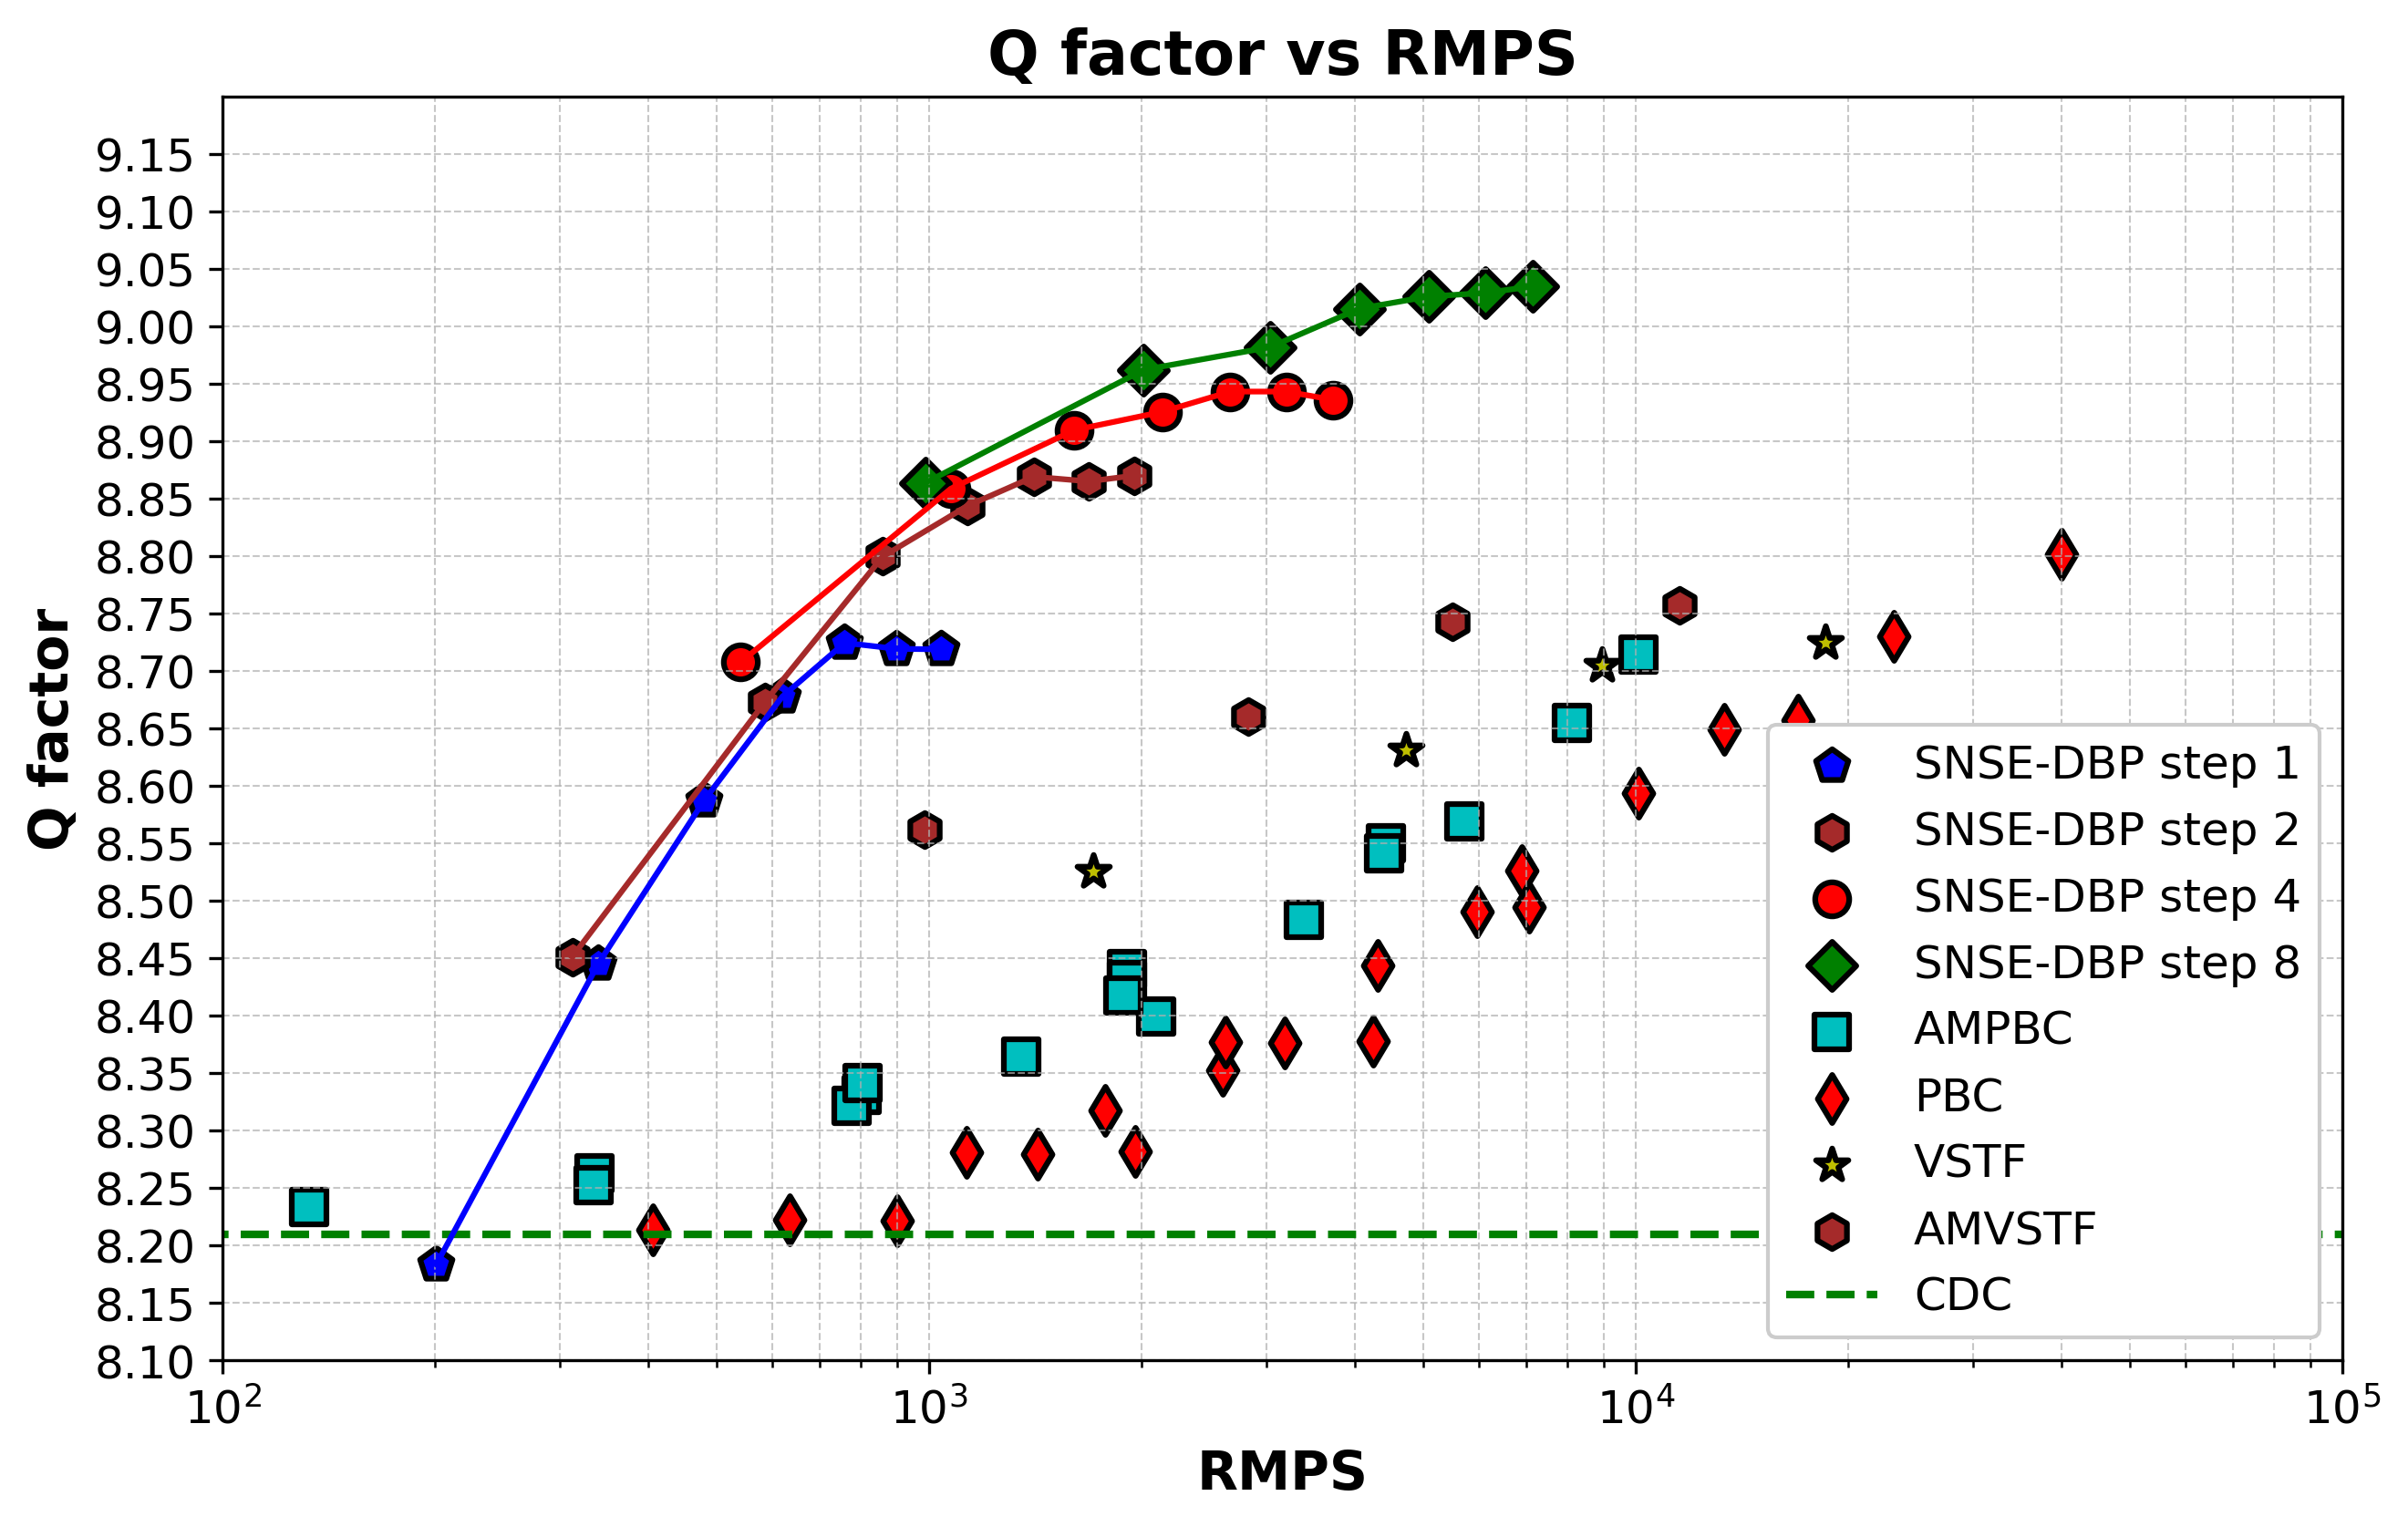

In [9]:
scatter_params = {
    'eqsnsedbp_effective_step1_': {'color': 'b', 'marker': 'p', 'label': 'SNSE-DBP step 1'},
    'eqsnsedbp_effective_step2_': {'color': 'brown', 'marker': 'h', 'label': 'SNSE-DBP step 2'},
    'eqsnsedbp_effective_step4_': {'color': 'r', 'marker': 'o', 'label': 'SNSE-DBP step 4'},
    'eqsnsedbp_effective_step8_': {'color': 'g', 'marker': 'D', 'label': 'SNSE-DBP step 8'},

    '_stftpbc_': {'color': 'y', 'marker': '*', 'label': 'VSTF'},
    '_stftampbc_': {'color': 'brown', 'marker': 'h', 'label': 'AMVSTF'},
    '_ampbc_': {'color': 'c', 'marker': 's', 'label': 'AMPBC'},
    '_pbc_': {'color': 'r', 'marker': 'd', 'label': 'PBC'},
    }



scatter_results(results_snse | results_ppc, scatter_params, cdc, ymax=9.2,ymin=8.1)
# scatter_results(results_fdbp|results_step, scatter_params, cdc)
plt.xlim(1e2,1e5)

rs,qs = get_step(1)
plt.plot(rs,qs,c='b')

rs,qs = get_step(2)
plt.plot(rs,qs,c='brown')

rs,qs = get_step(4)
plt.plot(rs,qs,c='r')

rs,qs = get_step(8)
plt.plot(rs,qs,c='g')


plt.savefig('fig/new_5_1.png')
# 图表说明：
# 1. 卷积建模的非线性算子更加高效
# 2. 多步的非线性补偿增益上限更高


In [10]:
from pkufiber.dsp.nonlinear_compensation.rmps import rmps_dbp
from scripts.visualize import get_base 
df = get_base()
results_dbp_sps2 = {} 

for i in [1,2,4,6,8]:
    results_dbp_sps2[f'DBP stps={i}'] = {'qfactor': df[(df['Nmodes'] == 2) & (df['Nch'] == 3) & (df['Rs'] == 80) & (df['Method'] == f'DBP stps={i}')].max()['Value'],
                                        'pch': 1,
                                        'rmps': rmps_dbp(i, 25, sps=2)}


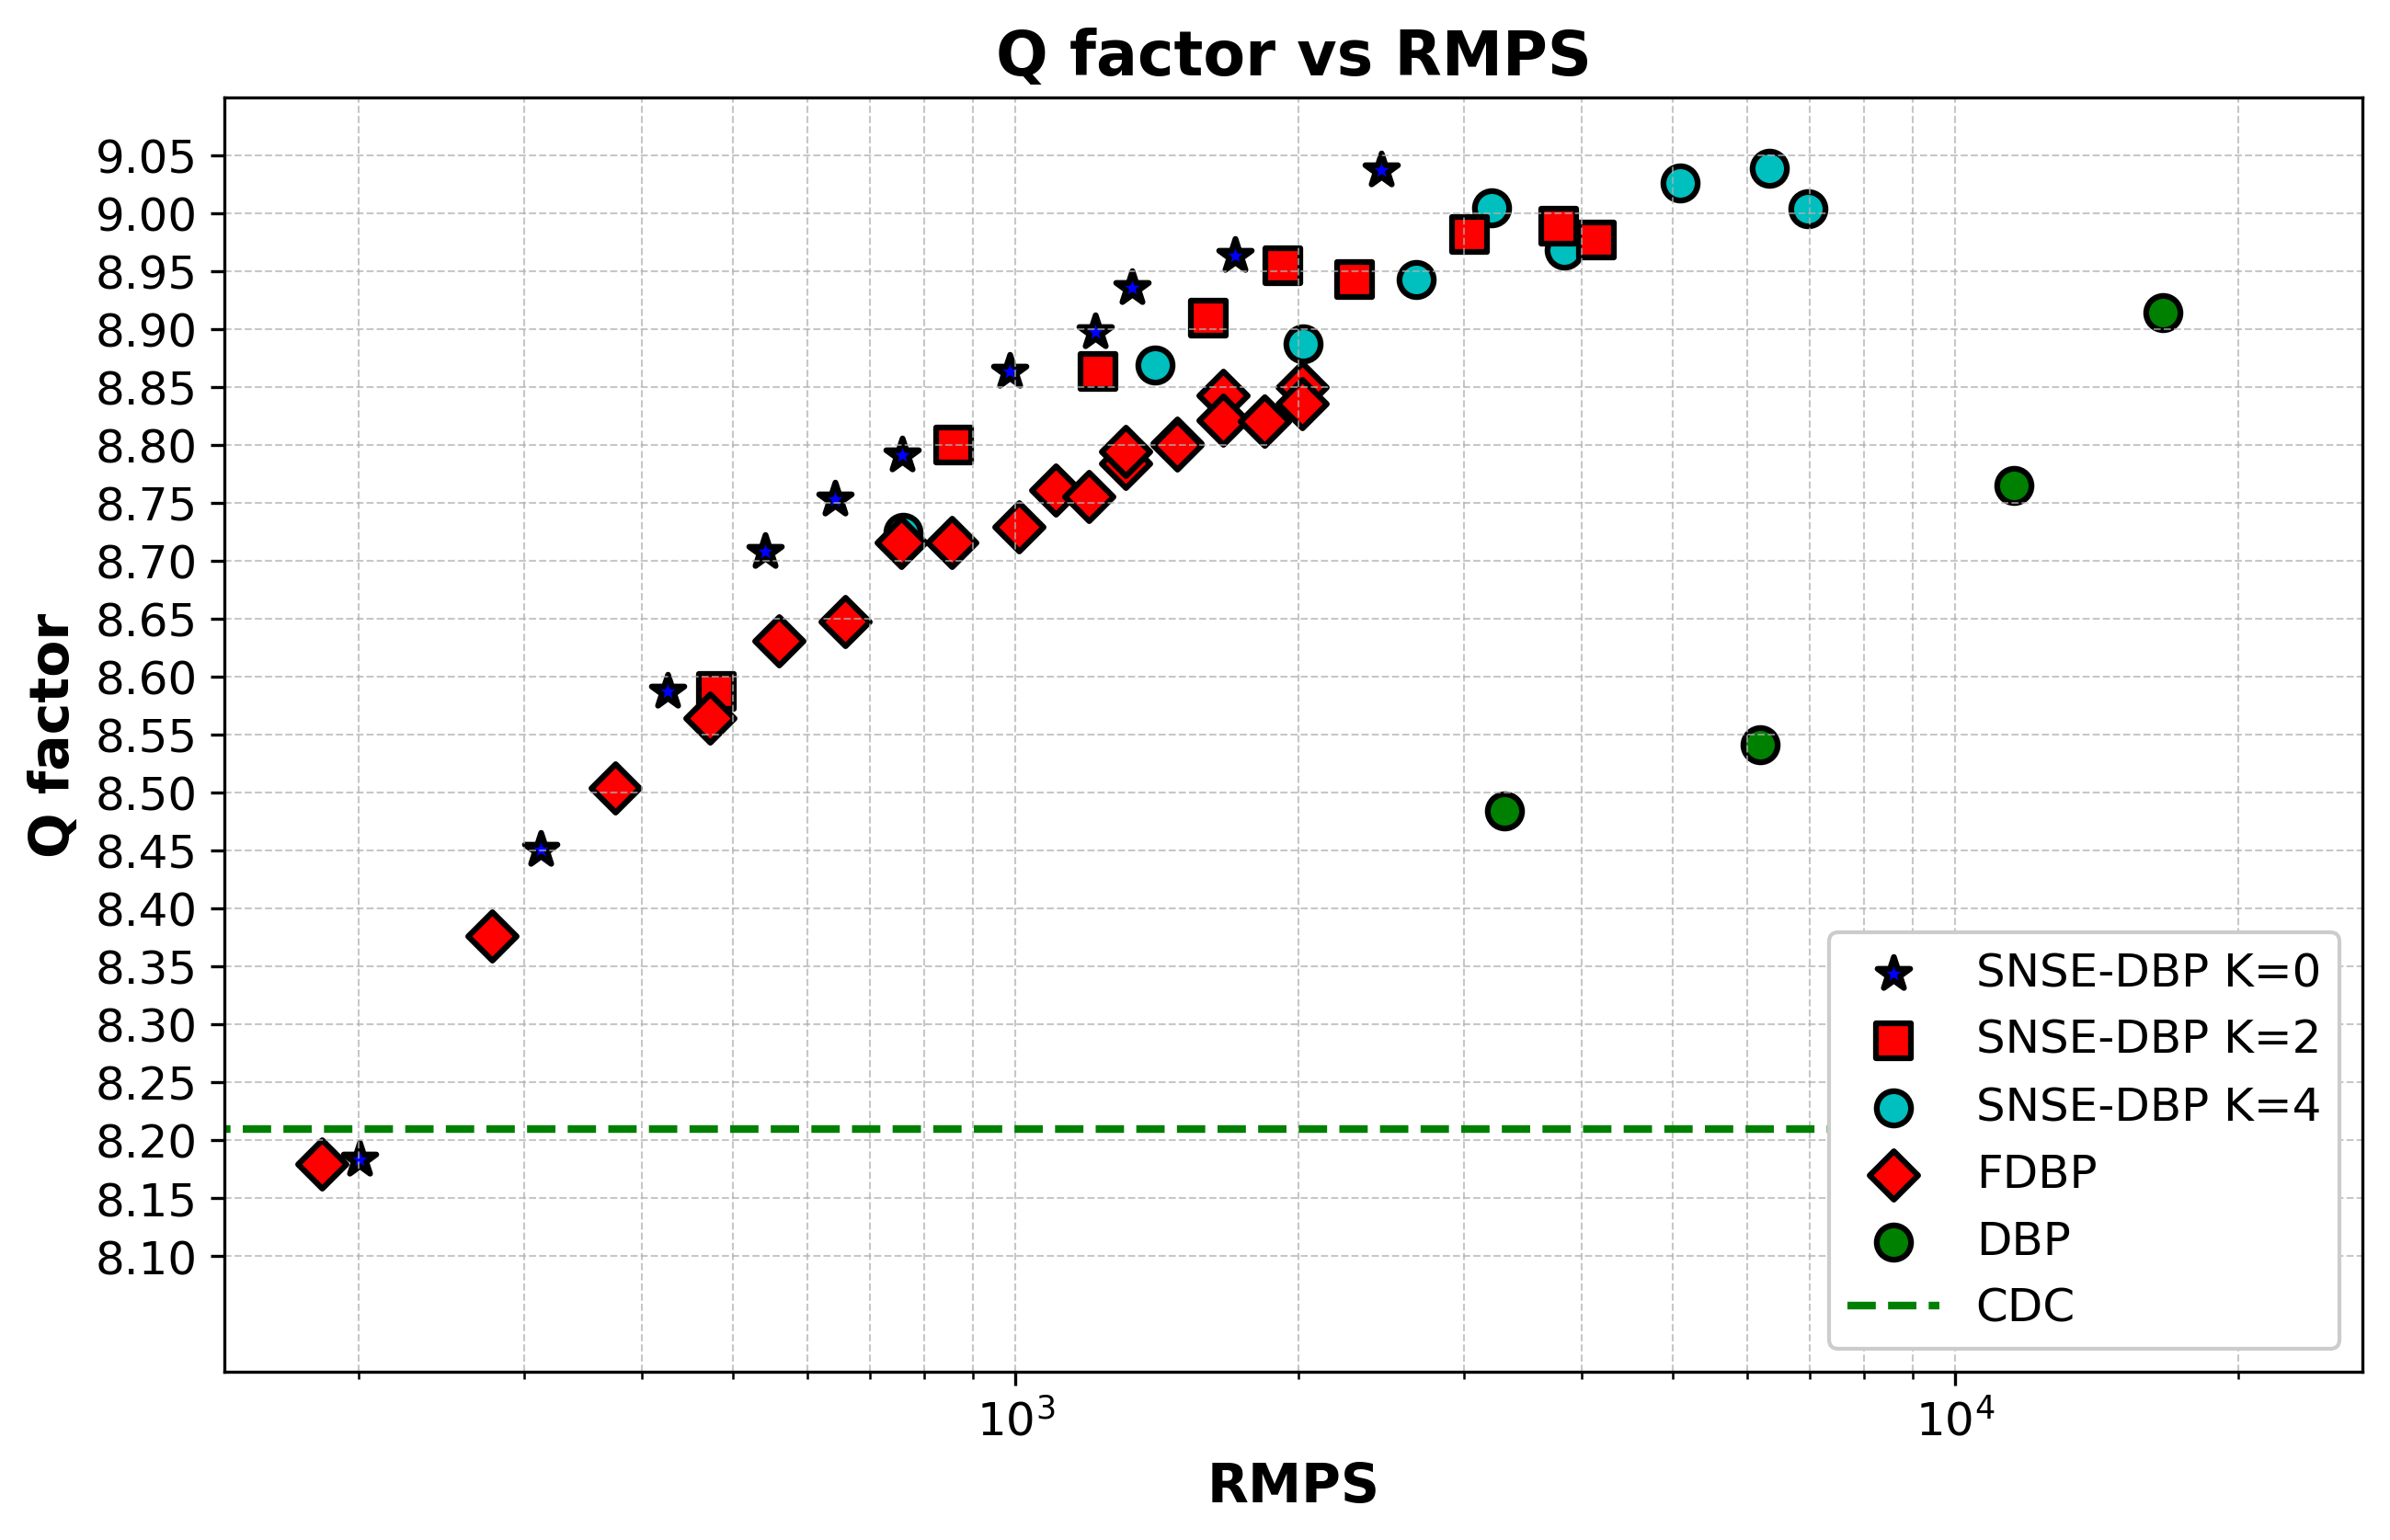

In [11]:
scatter_params = {
    'DBP': {'color': 'g', 'marker': 'o', 'label': 'DBP'},
    # '_fdbp_': {'color': 'm', 'marker': 'x', 'label': 'FDBP(sps=2)'},
    'eqfdbp': {'color': 'r', 'marker': 'D', 'label': 'FDBP'},
    'fwm0': {'color': 'b', 'marker': '*', 'label': 'SNSE-DBP K=0'},
    # 'fwm1': {'color': 'brown', 'marker': 'h', 'label': 'SNSE-DBP K=1'},
    'fwm2': {'color': 'r', 'marker': 's', 'label': 'SNSE-DBP K=2'},
    # 'fwm3': {'color': 'r', 'marker': 'o', 'label': 'SNSE-DBP FWM 3'},
    'fwm4': {'color': 'c', 'marker': 'o', 'label': 'SNSE-DBP K=4'},
    # 'fwm5': {'color': 'm', 'marker': 'D', 'label': 'SNSE-DBP K=5'},
    # 'fwm6': {'color': 'b', 'marker': 'D', 'label': 'SNSE-DBP FWM 6'},
    # 'fwm7': {'color': 'brown', 'marker': 'D', 'label': 'SNSE-DBP FWM 7'},

    # '_stftpbc_': {'color': 'y', 'marker': '*', 'label': 'VSTF'},
    # '_stftampbc_': {'color': 'brown', 'marker': 'h', 'label': 'AMVSTF'},
    # '_ampbc_': {'color': 'c', 'marker': 's', 'label': 'AMPBC'},
    # '_pbc_': {'color': 'r', 'marker': 'o', 'label': 'PBC'},
    }

scatter_results(results_snse | results_ppc | results_fdbp_sps1 | results_dbp_sps2 | results_fdbp_sps2, scatter_params, cdc, ymin=8.1, ymax=9.1, xmax=2e4)
plt.ylim(8, 9.1)
# scatter_results(results_fdbp|results_step, scatter_params, cdc)
plt.savefig('fig/new_5_2.png')

# 图表说明：
# 1. SNSE-DBP FWM 0的性能优于FDBP
# 2. SNSE-DBP FWM的性能随着FWM的增加而降低。


In [12]:
df[(df['Nmodes'] == 2) & (df['Nch'] == 3) & (df['Rs'] == 160) & (df['Method'] == 'DBP stps=32')]

,Nmodes,Rs,Nch,Pch,Method,Value
723,2,160,3,-3,DBP stps=32,2.927334
736,2,160,3,-2,DBP stps=32,3.845773
749,2,160,3,-1,DBP stps=32,4.695248
762,2,160,3,0,DBP stps=32,5.559287
775,2,160,3,1,DBP stps=32,6.376801
788,2,160,3,2,DBP stps=32,7.095518
801,2,160,3,3,DBP stps=32,7.724684
814,2,160,3,4,DBP stps=32,7.994588
827,2,160,3,5,DBP stps=32,8.733006
840,2,160,3,6,DBP stps=32,8.580327
